**Import packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from copy import copy
from tqdm import tqdm
import json

import torch
from transformers import BertModel, BertTokenizerFast
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score, classification_report


**Read all relation labels**

In [2]:
loc = './dataset/NYT29/relations.txt'
relations = [f for f in open(loc, 'r').read().splitlines()]
relations.append('other')
RELATION_LABELS = {r: i for i, r in enumerate(relations)}
LABEL2RELATION = {i: r for i, r in enumerate(relations)}

print('Dataset contains {} relations:'.format(len(relations)))

for k in RELATION_LABELS.keys():
    print('{}: {}'.format(RELATION_LABELS[k], k))

Dataset contains 30 relations:
0: /location/administrative_division/country
1: /location/country/capital
2: /location/country/administrative_divisions
3: /location/neighborhood/neighborhood_of
4: /location/location/contains
5: /people/person/nationality
6: /people/person/place_lived
7: /people/deceased_person/place_of_death
8: /business/person/company
9: /location/us_state/capital
10: /people/person/place_of_birth
11: /people/person/children
12: /business/company/founders
13: /business/company/place_founded
14: /sports/sports_team/location
15: /people/person/ethnicity
16: /people/ethnicity/geographic_distribution
17: /people/person/religion
18: /business/company/major_shareholders
19: /location/province/capital
20: /location/br_state/capital
21: /business/company/advisors
22: /film/film_location/featured_in_films
23: /film/film/featured_film_locations
24: /location/us_county/county_seat
25: /time/event/locations
26: /people/deceased_person/place_of_burial
27: /people/place_of_interment

**Hyperparameters**

In [3]:
NUM_CLASSES = len(relations)
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 128

LR = 2e-5
TRAINING_BATCH_SIZE = 16
VAL_BATCH_SIZE = 1
EPOCHS = 4
DROPOUT = 0.3
NUM_WORKERS = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Define dataset class for processing inputs**

In [4]:
def clean_entity(entity_list):
    if not isinstance(entity_list, list):
        entity_list = [entity_list]
    # remove white spaces and newline characters
    for idx, e in enumerate(entity_list):
        e = e.strip()
        entity_list[idx] = e
    return entity_list

class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dict, tokenizer, max_len, add_CLS=True):
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.sentences = dataset_dict['sent']
        self.relation_tuples = dataset_dict['tup']
        if len(self.sentences) != len(self.relation_tuples):
            raise ValueError('The number of sentences and relation tuples are not equal.')
        self.add_CLS = add_CLS
        
        self.separator = '|'
    
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, index):
        # get the sentence and the corresponding relation tuple
        sentence = self.sentences[index]
        relation_tuples = self.relation_tuples[index]
        relation_tuples = relation_tuples.split(self.separator)

        # get all entities mentioned in the sentence
        all_entity_pairs_mentioned = [clean_entity(x.split(';')[:2]) for x in relation_tuples]
        all_entities = [item for sublist in all_entity_pairs_mentioned for item in sublist]
        all_entities = {e: f'e_{i+1}' for i, e in enumerate(set(all_entities))}
        all_possible_entity_pairs = [[x, y] for x in all_entities for y in all_entities if x != y]

        input_ids = []
        attention_masks = []
        target_labels = []
        # e1_mask = []
        # e2_mask = []
        # position_ids_e1 = []
        # position_ids_e2 = []

        for entity_pair in all_possible_entity_pairs:
            ent1, ent2 = entity_pair
            positive_example_found = False
            # positive examples
            for er in relation_tuples:
                entity1, entity2, relation = clean_entity(er.split(';'))
                if ent1 != entity1 or ent2 != entity2:
                    continue
                marked_sentence = f"[{all_entities[entity1]}]{entity1}[\{all_entities[entity1]}] and " \
                                f"[{all_entities[entity2]}]{entity2}[\{all_entities[entity2]}] have some relation in the context: {sentence}"
                encoding = self.tokenizer(marked_sentence, max_length=self.max_len, padding='max_length', 
                                          return_attention_mask=True, truncation=True, add_special_tokens=self.add_CLS,
                                          return_tensors='pt')
                input_ids.append(encoding['input_ids'])
                attention_masks.append(encoding['attention_mask'])
                target_labels.append(RELATION_LABELS[relation])
                positive_example_found = True
                break
            if not positive_example_found:
                # negative examples
                entity1, entity2 = entity_pair
                marked_sentence = f"[{all_entities[entity1]}]{entity1}[\{all_entities[entity1]}] and " \
                                  f"[{all_entities[entity2]}]{entity2}[\{all_entities[entity2]}] have no relation in the context: {sentence}"
                encoding = self.tokenizer(marked_sentence, max_length=self.max_len, padding='max_length', 
                                          return_attention_mask=True, truncation=True, add_special_tokens=self.add_CLS,
                                          return_tensors='pt')
                input_ids.append(encoding['input_ids'])
                attention_masks.append(encoding['attention_mask'])
                target_labels.append(RELATION_LABELS['other'])

        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        target_labels = torch.tensor(target_labels, dtype=torch.long)
        return {'id': input_ids, 'mask': attention_masks, 'target': target_labels}


**Define classifier**

In [5]:
class Classifier(nn.Module):
    def __init__(self, dropout=0.3, num_classes=30):
        super(Classifier, self).__init__()

        self.bertmodel = BertModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bertmodel.config.hidden_size, num_classes)

        self.loss_fcn = nn.CrossEntropyLoss()

    def forward(self, ids, masks, targets, token_type_id=None, e1_mask=None, e2_mask=None, position_ids_e1=None, position_ids_e2=None):
        outputs = self.bertmodel(ids, attention_mask=masks)
        pooled_out = outputs[1]
        pooled_out = self.dropout(pooled_out)
        logits = self.classifier(pooled_out)
        
        _, prediction = torch.max(logits, dim=1)

        loss = self.loss_fcn(logits, targets.view(-1))
        return loss, prediction

**Load the dataset**

In [6]:
dataset_dir = './dataset/NYT29/'

file_types = ['.sent', '.tup']
datasets = ['train', 'test', 'dev']

train = {}
test = {}
dev = {}

for d in datasets:
    for t in file_types:
        with open(os.path.join(dataset_dir, f'{d}{t}'), 'r') as f:
            if t == '.sent':
                exec(f'{d}["sent"] = f.read().splitlines()')
            else:
                exec(f'{d}["tup"] = f.read().splitlines()')

Load the pretrained tokenizer

In [7]:
tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

train_dataset = Dataset(train, tokenizer, MAX_LEN)
test_dataset = Dataset(test, tokenizer, MAX_LEN)
dev_dataset = Dataset(dev, tokenizer, MAX_LEN)

print('Train dataset size: {}'.format(len(train_dataset)))
print('Test dataset size: {}'.format(len(test_dataset)))
print('Dev dataset size: {}'.format(len(dev_dataset)))

Train dataset size: 63306
Test dataset size: 4006
Dev dataset size: 7033


Script for training the model

In [8]:
def trainer(model, train_dataset_loader, dev_dataset_loader, optimizer, epochs, device):
    ''' train '''
    training_loss = []
    training_accuracy = []
    ''' validation '''
    validation_loss = []
    validation_accuracy = []
    for e in range(epochs):
        train_sample_count = 0
        correct_predictions = 0
        model.train()
        for data in tqdm(train_dataset_loader, leave=False):
            ids = data['id'].to(device)
            masks = data['mask'].to(device)
            targets = data['target'].to(device)
            # e1_mask = data['e1_mask'].to(device)
            # e2_mask = data['e2_mask'].to(device)
            # position_ids_e1 = data['position_ids_e1'].to(device)
            # position_ids_e2 = data['position_ids_e2'].to(device)

            loss, prediction = model(ids=ids, masks=masks, targets=targets)
                                    #  e1_mask=e1_mask, e2_mask=e2_mask, 
                                    #  position_ids_e1=position_ids_e1, position_ids_e2=position_ids_e2)
            training_loss.append(loss.item())
            correct_predictions += torch.sum(prediction == targets).cpu().detach().numpy()
            train_sample_count += len(targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        training_accuracy.append((e, correct_predictions / train_sample_count))

        model.eval()
        val_sample_count = 0
        correct_predictions = 0
        for data in tqdm(dev_dataset_loader):
            ids = data['id'].to(device)
            masks = data['mask'].to(device)
            targets = data['target'].to(device)

            loss, prediction = model(ids, masks, targets)
            validation_loss.append(loss.item())
            correct_predictions += torch.sum(prediction == targets).cpu().detach().numpy()
            val_sample_count += len(targets)
            
        validation_accuracy.append((e, correct_predictions / val_sample_count))    

        tqdm.write(f'Epoch: {e}, Training loss: {np.mean(training_loss)}, Training accuracy: {sum(list(zip(*training_accuracy))[1])},' \
                   f' Validation loss: {np.mean(validation_loss)}, Validation accuracy: {sum(list(zip(*validation_accuracy))[1])}')

    # save the trained models
    model_checkpoint = dict()
    model_checkpoint['model_state_dict'] = model.state_dict()
    model_checkpoint['optimizer_state_dict'] = optimizer.state_dict()
    model_checkpoint['training_loss'] = training_loss
    model_checkpoint['training_accuracy'] = training_accuracy
    model_checkpoint['validation_loss'] = validation_loss
    model_checkpoint['validation_accuracy'] = validation_accuracy
    torch.save(model_checkpoint, f'./save_data/model_checkpoint.pth')
    return training_loss, training_accuracy, validation_loss, validation_accuracy

**Define collate function for dataloader**

Need to define how to stack batches since different sentences can have different lengths

In [9]:
def collate_fcn(batch):
    return {'id': torch.cat([x['id'] for x in batch], dim=0),
            'mask': torch.cat([x['mask'] for x in batch], dim=0),
            'target': torch.cat([x['target'] for x in batch], dim=0)}

Define the dataset loaders to pass to the training script

In [10]:
params_dataLoader = {'batch_size': TRAINING_BATCH_SIZE,
                     'shuffle': True,
                     'num_workers': NUM_WORKERS,
                     'collate_fn': collate_fcn}
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, **params_dataLoader)

params_dataLoader_eval = {'batch_size': VAL_BATCH_SIZE,
                          'shuffle': True,
                          'num_workers': 0,
                          'collate_fn': collate_fcn}
dev_dataset_loader = torch.utils.data.DataLoader(dev_dataset, **params_dataLoader)


**Initialize model and optimizer**

In [11]:
model = Classifier(dropout=DROPOUT, num_classes=NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

**Train the classifier**

Text(0.5, 1.0, 'Validation Accuracy')

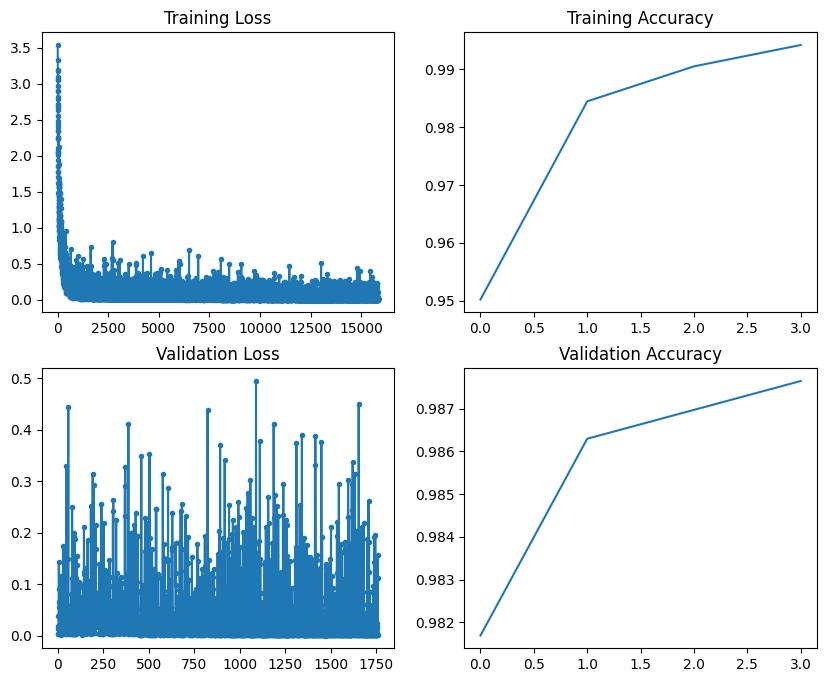

In [12]:
load = all([os.path.exists(f'save_data/{f}') for f in ['model_checkpoint.pth', 'training_loss.json', 'training_accuracy.json']])

if load:
    model_dir = 'save_data/model_checkpoint.pth'
    model_checkpoint = torch.load(model_dir)
    model.load_state_dict(model_checkpoint['model_state_dict'])

    fname = os.path.join(f'./save_data/training_loss.json')
    with open(fname, 'r') as f:
        training_loss = json.load(f)
    fname = os.path.join(f'./save_data/training_accuracy.json')
    with open(fname, 'r') as f:
        training_accuracy = json.load(f)
    fname = os.path.join(f'./save_data/validation_loss.json')
    with open(fname, 'r') as f:
        validation_loss = json.load(f)
    fname = os.path.join(f'./save_data/validation_accuracy.json')
    with open(fname, 'r') as f:
        validation_accuracy = json.load(f)
else:
    if not os.path.exists('save_data/'):
        os.makedirs('save_data')
    training_loss, training_accuracy, validation_loss, validation_accuracy = trainer(model, train_dataset_loader, dev_dataset_loader, optimizer, EPOCHS, device)

    fname = os.path.join(f'./save_data/training_loss.json')
    with open(fname, 'w') as f:
        json.dump(training_loss, f)
    fname = os.path.join(f'./save_data/training_accuracy.json')
    with open(fname, 'w') as f:
        json.dump(training_accuracy, f)
    fname = os.path.join(f'./save_data/validation_loss.json')
    with open(fname, 'w') as f:
        json.dump(validation_loss, f)
    fname = os.path.join(f'./save_data/validation_accuracy.json')
    with open(fname, 'w') as f:
        json.dump(validation_accuracy, f)

_, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(training_loss, marker='.')
ax[0, 0].set_title('Training Loss')
ax[0, 1].plot(*zip(*training_accuracy))
ax[0, 1].set_title('Training Accuracy')
ax[1, 0].plot(validation_loss, marker='.')
ax[1, 0].set_title('Validation Loss')
ax[1, 1].plot(*zip(*validation_accuracy))
ax[1, 1].set_title('Validation Accuracy')

ax[0, 1].set_ylim([0, 1])
ax[1, 1].set_ylim([0, 1])

Script for evaluating the trained model

In [13]:
def eval(model, dataset_loader, params_dataLoader, device):
    y_pred = np.empty(0)
    y_true = np.empty(0)
    for i, data in enumerate(tqdm(dataset_loader)):
        ids = data['id'].to(device)
        masks = data['mask'].to(device)
        targets = data['target'].to(device)

        y_true = np.concatenate((y_true, targets.cpu().detach().numpy()))
        with torch.no_grad():
            _, prediction = model(ids, masks, targets)
            y_pred = np.concatenate((y_pred, prediction.cpu().detach().numpy()))
    
    pred_relation = [LABEL2RELATION[p] for p in y_pred]
    true_relation = [LABEL2RELATION[p] for p in y_true]
    report = f1_score(true_relation, pred_relation, labels=list(LABEL2RELATION.values()), average='micro')

    print('Micro Average F1-Score: {}'.format(report))

    return report

**Evaluate the trained classifier**

In [14]:
params_dataLoader_eval = {'batch_size': VAL_BATCH_SIZE,
                          'shuffle': False,
                          'num_workers': 0,
                          'collate_fn': collate_fcn}
test_dataset_loader = torch.utils.data.DataLoader(test_dataset, **params_dataLoader)

print('-- Test set:')
test_report = eval(model, test_dataset_loader, params_dataLoader_eval, device)

-- Test set:


100%|██████████| 251/251 [00:39<00:00,  6.42it/s]


Micro Average F1-Score: 0.9192520186995325


In [18]:
params_dataLoader_eval = {'batch_size': VAL_BATCH_SIZE,
                          'shuffle': False,
                          'num_workers': 0,
                          'collate_fn': collate_fcn}
dev_dataset_loader = torch.utils.data.DataLoader(dev_dataset, **params_dataLoader)

print('-- Dev set:')
test_report = eval(model, dev_dataset_loader, params_dataLoader_eval, device)

-- Dev set:


100%|██████████| 440/440 [01:08<00:00,  6.44it/s]

Micro Average F1-Score: 0.9875261152759002


In [16]:
params_dataLoader_eval = {'batch_size': VAL_BATCH_SIZE,
                          'shuffle': False,
                          'num_workers': 0,
                          'collate_fn': collate_fcn}
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, **params_dataLoader)

print('-- Train set:')
train_report = eval(model, train_dataset_loader, params_dataLoader_eval, device)

-- Train set:


100%|██████████| 3957/3957 [09:55<00:00,  6.64it/s]


Micro Average F1-Score: 0.9976635833253631


Save the output in a pdf

In [19]:
%%capture
import subprocess

subprocess.call('jupyter nbconvert hw2_906466769.ipynb --to pdf --output hw2_906466769_Output.pdf', shell=True)

[NbConvertApp] Converting notebook hw2_906466769.ipynb to pdf
[NbConvertApp] Support files will be in hw2_906466769_Output_files/
[NbConvertApp] Making directory ./hw2_906466769_Output_files
[NbConvertApp] Writing 73835 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 126693 bytes to hw2_906466769_Output.pdf
